In [1]:
# COMMON SETUP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

DATA_ROOT = Path("/kaggle/input/fmcg-dataset")
OUT_ROOT = Path("/kaggle/working")
OUT_ROOT.mkdir(parents=True, exist_ok=True)


Loaded all Kaggle FMCG tables.
daily_ts shape: 7,305,000 rows x 66 cols
Date range: 2004-01-01 00:00:00 → 2023-12-31 00:00:00
Unique SKUs: 50 Locations: 20
=== SKU MASTER ===
Shape: (50, 16)
Columns: ['sku_id', 'sku_name', 'brand', 'category', 'segment', 'pack_size', 'material', 'base_price', 'cost', 'mrp', 'shelf_life_days', 'life_category', 'abc_class', 'min_order_qty', 'lead_time_days', 'is_seasonal']

Dtypes:
sku_id              object
sku_name            object
brand               object
category            object
segment             object
pack_size           object
material            object
base_price         float64
cost               float64
mrp                float64
shelf_life_days      int64
life_category       object
abc_class           object
min_order_qty        int64
lead_time_days       int64
is_seasonal          int64
dtype: object

Missing values:
sku_id             0
sku_name           0
brand              0
category           0
segment            0
pack_size      

,sku_id,sku_name,brand,category,segment,pack_size,material,base_price,cost,mrp,shelf_life_days,life_category,abc_class,min_order_qty,lead_time_days,is_seasonal
0,SKU_0001,Brand_H_BIS_1,Brand_E,BISCUITS,Economy,1kg,POUCH,108.05,56.73,128.78,90,SEMI_PERISHABLE,B,48,9,0
1,SKU_0002,Brand_F_PER_2,Brand_B,PERSONALCARE,Premium,200ml,GLASS,485.56,317.03,534.80,365,STABLE,A,24,12,0
2,SKU_0003,Brand_C_HOM_3,Brand_G,HOMECARE,Premium,500ml,BOX,487.40,317.73,552.76,365,STABLE,A,48,10,1
3,SKU_0004,Brand_B_BEV_4,Brand_D,BEVERAGES,Economy,100g,GLASS,27.66,17.25,30.62,90,SEMI_PERISHABLE,C,48,3,0
4,SKU_0005,Brand_D_BEV_5,Brand_F,BEVERAGES,Premium,250ml,PET,119.81,73.38,141.26,90,SEMI_PERISHABLE,C,24,9,0


----------------------------------------------------------------------
=== LOCATION MASTER ===
Shape: (20, 9)
Columns: ['location_id', 'city', 'region', 'location_type', 'population', 'avg_income_index', 'distribution_tier', 'storage_capacity_units', 'cold_storage_available']

Dtypes:
location_id                object
city                       object
region                     object
location_type              object
population                  int64
avg_income_index          float64
distribution_tier          object
storage_capacity_units      int64
cold_storage_available      int64
dtype: object

Missing values:
location_id               0
city                      0
region                    0
location_type             0
population                0
avg_income_index          0
distribution_tier         0
storage_capacity_units    0
cold_storage_available    0
dtype: int64

First 5 rows:


,location_id,city,region,location_type,population,avg_income_index,distribution_tier,storage_capacity_units,cold_storage_available
0,LOC_001,London,Greater London,Semi-Urban,184903,1.46,Tier1,35220,1
1,LOC_002,Birmingham,Midlands,Semi-Urban,139693,1.18,Tier2,30242,1
2,LOC_003,Manchester,North West,Semi-Urban,116195,1.09,Tier3,32913,1
3,LOC_004,Leeds,North West,Urban,98500,0.99,Tier2,31546,1
4,LOC_005,Glasgow,Scotland,Semi-Urban,157620,0.97,Tier2,40264,1


----------------------------------------------------------------------
=== FESTIVAL CALENDAR ===
Shape: (320, 4)
Columns: ['date', 'festival', 'demand_multiplier', 'festival_duration_days']

Dtypes:
date                      datetime64[ns]
festival                          object
demand_multiplier                float64
festival_duration_days             int64
dtype: object

Missing values:
date                      0
festival                  0
demand_multiplier         0
festival_duration_days    0
dtype: int64

First 5 rows:


,date,festival,demand_multiplier,festival_duration_days
0,2004-01-01,New_Years_Day,1.4,3
1,2004-02-14,Valentines_Day,1.6,3
2,2004-03-10,Mothers_Day,1.8,3
3,2004-04-21,Easter_Sunday,2.0,7
4,2004-05-06,May_Bank_Holiday,1.5,3


----------------------------------------------------------------------
=== MONTHLY MACRO ===
Shape: (240, 6)
Columns: ['month', 'gdp_growth', 'cpi_index', 'consumer_confidence', 'fuel_price_index', 'exchange_rate_gbp_usd']

Dtypes:
month                     object
gdp_growth               float64
cpi_index                float64
consumer_confidence      float64
fuel_price_index         float64
exchange_rate_gbp_usd    float64
dtype: object

Missing values:
month                    0
gdp_growth               0
cpi_index                0
consumer_confidence      0
fuel_price_index         0
exchange_rate_gbp_usd    0
dtype: int64

First 5 rows:


,month,gdp_growth,cpi_index,consumer_confidence,fuel_price_index,exchange_rate_gbp_usd
0,2004-01-01,0.0209,100.02,104.48,100.40,1.3061
1,2004-02-01,0.0196,100.54,102.25,99.84,1.2992
2,2004-03-01,0.0173,101.45,99.36,100.59,1.2882
3,2004-04-01,0.0185,101.48,94.29,101.17,1.2752
4,2004-05-01,0.0177,101.78,104.54,101.47,1.2711


----------------------------------------------------------------------
=== DAILY TIMESERIES ===
Shape: (7305000, 66)
Columns: ['date', 'sku_id', 'location_id', 'base_price', 'brand', 'category', 'sku_name', 'segment', 'pack_size', 'material', 'cost', 'mrp', 'shelf_life_days', 'life_category', 'abc_class', 'min_order_qty', 'lead_time_days', 'is_seasonal', 'city', 'region', 'location_type', 'population', 'avg_income_index', 'distribution_tier', 'storage_capacity_units', 'cold_storage_available', 'channel', 'price', 'promo_flag', 'promo_depth', 'comp_promo_flag', 'expected_demand', 'actual_demand', 'unfulfilled_demand', 'opening_stock', 'incoming_stock', 'closing_stock', 'returns', 'waste_spoiled', 'stockout_flag', 'mos', 'festival_uplift', 'weather_factor', 'macro_factor', 'safety_stock', 'reorder_point', 'month', 'day_of_week', 'day_of_month', 'week_of_year', 'is_weekend', 'quarter', 'year', 'loc_lag_1', 'loc_lag_7', 'loc_lag_14', 'loc_lag_30', 'loc_rolling_7_mean', 'loc_rolling_30_mean

,date,sku_id,location_id,base_price,brand,category,sku_name,segment,pack_size,material,...,loc_lag_30,loc_rolling_7_mean,loc_rolling_30_mean,loc_rolling_7_std,chan_lag_1,chan_rolling_7_mean,elasticity_proxy,days_since_promo,promo_run,demand_yoy_pct_change
0,2004-01-01,SKU_0001,LOC_001,108.05,Brand_E,BISCUITS,Brand_H_BIS_1,Economy,1kg,POUCH,...,0,0.00,0.00,0.000000,0,0.0,NaN,0,0,NaN
1,2004-01-02,SKU_0001,LOC_001,108.05,Brand_E,BISCUITS,Brand_H_BIS_1,Economy,1kg,POUCH,...,0,1449.00,1449.00,0.000000,0,0.0,NaN,0,0,NaN
2,2004-01-03,SKU_0001,LOC_001,108.05,Brand_E,BISCUITS,Brand_H_BIS_1,Economy,1kg,POUCH,...,0,724.50,724.50,1024.597726,1449,1449.0,NaN,0,0,NaN
3,2004-01-04,SKU_0001,LOC_001,108.05,Brand_E,BISCUITS,Brand_H_BIS_1,Economy,1kg,POUCH,...,0,519.00,519.00,807.211868,0,724.5,58.290323,0,0,NaN
4,2004-01-05,SKU_0001,LOC_001,108.05,Brand_E,BISCUITS,Brand_H_BIS_1,Economy,1kg,POUCH,...,0,389.25,389.25,708.332020,0,724.5,NaN,0,0,NaN


----------------------------------------------------------------------
=== SHIPMENT DATA ===
Shape: (7171071, 9)
Columns: ['shipment_id', 'sku_id', 'location_id', 'ship_date', 'receipt_date', 'quantity', 'lead_time_actual', 'lead_time_expected', 'on_time']

Dtypes:
shipment_id           object
sku_id                object
location_id           object
ship_date             object
receipt_date          object
quantity               int64
lead_time_actual       int64
lead_time_expected     int64
on_time                int64
dtype: object

Missing values:
shipment_id           0
sku_id                0
location_id           0
ship_date             0
receipt_date          0
quantity              0
lead_time_actual      0
lead_time_expected    0
on_time               0
dtype: int64

First 5 rows:


,shipment_id,sku_id,location_id,ship_date,receipt_date,quantity,lead_time_actual,lead_time_expected,on_time
0,SHIP_00000001,SKU_0001,LOC_001,2003-12-21,2004-01-01,150,11,9,0
1,SHIP_00000002,SKU_0001,LOC_001,2003-12-23,2004-01-02,100,10,9,0
2,SHIP_00000003,SKU_0001,LOC_001,2003-12-23,2004-01-03,100,11,9,0
3,SHIP_00000004,SKU_0001,LOC_001,2003-12-28,2004-01-04,100,7,9,1
4,SHIP_00000005,SKU_0001,LOC_001,2003-12-27,2004-01-05,125,9,9,1


----------------------------------------------------------------------
=== COMPETITOR ACTIVITY ===
Shape: (7305, 3)
Columns: ['date', 'competitor_promo_intensity', 'competitor_price_pressure']

Dtypes:
date                          datetime64[ns]
competitor_promo_intensity           float64
competitor_price_pressure            float64
dtype: object

Missing values:
date                          0
competitor_promo_intensity    0
competitor_price_pressure     0
dtype: int64

First 5 rows:


,date,competitor_promo_intensity,competitor_price_pressure
0,2004-01-01,0.233,1.006
1,2004-01-02,0.000,1.017
2,2004-01-03,0.000,1.013
3,2004-01-04,0.000,1.025
4,2004-01-05,0.000,1.011


----------------------------------------------------------------------
=== WEATHER DATA ===
Shape: (7305, 6)
Columns: ['date', 'temperature_c', 'rainfall_mm', 'humidity_pct', 'weather_demand_factor', 'is_winter']

Dtypes:
date                     datetime64[ns]
temperature_c                   float64
rainfall_mm                     float64
humidity_pct                    float64
weather_demand_factor           float64
is_winter                         int64
dtype: object

Missing values:
date                     0
temperature_c            0
rainfall_mm              0
humidity_pct             0
weather_demand_factor    0
is_winter                0
dtype: int64

First 5 rows:


,date,temperature_c,rainfall_mm,humidity_pct,weather_demand_factor,is_winter
0,2004-01-01,5.3,0.7,81.1,1.0,1
1,2004-01-02,0.7,2.2,74.5,1.1,1
2,2004-01-03,1.4,19.1,92.0,1.1,1
3,2004-01-04,-0.7,0.0,100.0,1.1,1
4,2004-01-05,1.0,4.0,89.5,1.1,1


----------------------------------------------------------------------

=== DATA QUALITY: daily_ts ===

Missing (non-zero):
                       missing_count  missing_%
demand_yoy_pct_change        2363527      32.35
elasticity_proxy             1521070      20.82

Duplicate (date, sku_id, location_id): 0

Zero actual_demand: 2,103,264 (28.79%)
Negative actual_demand: 0

=== TARGET: actual_demand DISTRIBUTION ===
count    7.305000e+06
mean     1.048307e+02
std      1.572566e+02
min      0.000000e+00
25%      0.000000e+00
50%      7.700000e+01
75%      1.270000e+02
max      3.594000e+03
Name: actual_demand, dtype: float64

Outliers (IQR): 350,461 (4.80%)


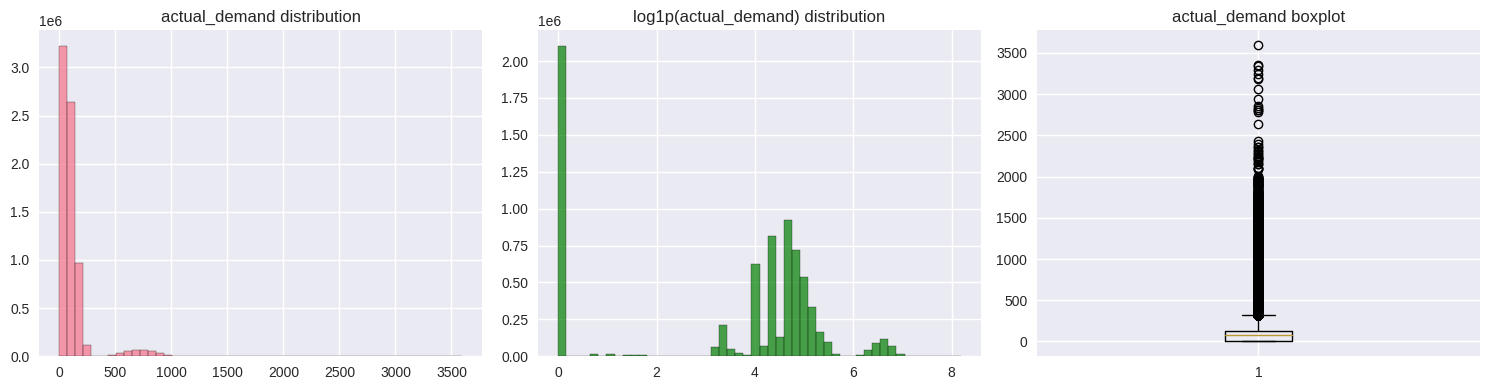


=== CORRELATIONS WITH actual_demand (numeric columns) ===

Top 10 positive:
loc_lag_7                0.297211
loc_lag_14               0.295051
demand_yoy_pct_change    0.234477
incoming_stock           0.227205
opening_stock            0.064476
reorder_point            0.049350
closing_stock            0.034161
returns                  0.031712
festival_uplift          0.030130
mos                      0.028127
Name: actual_demand, dtype: float64

Top 10 negative:
elasticity_proxy      -0.002255
loc_rolling_30_mean   -0.012267
stockout_flag         -0.016002
chan_rolling_7_mean   -0.023729
loc_lag_1             -0.044331
loc_lag_30            -0.049264
chan_lag_1            -0.114727
is_weekend            -0.140651
day_of_week           -0.333216
days_since_promo            NaN
Name: actual_demand, dtype: float64


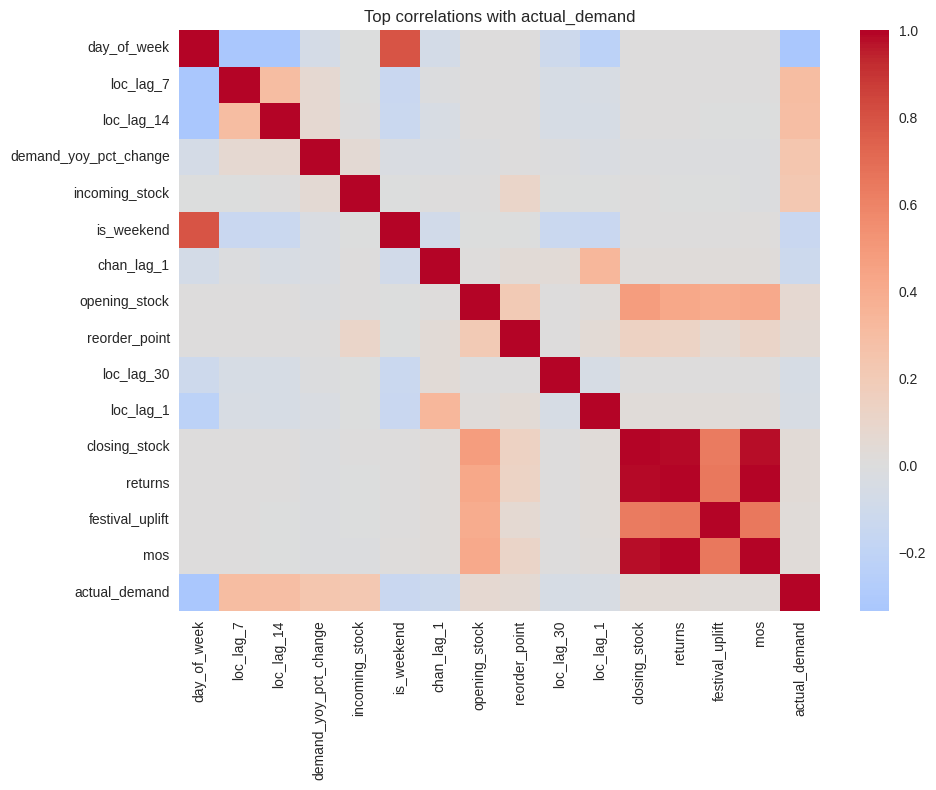


=== TEMPORAL PATTERNS (AGGREGATED) ===

Weekly average:
dayofweek
0    314453.904123
1     69888.050815
2     69815.716203
3     70279.109195
4     69774.638889
5     69813.278736
6     69923.824713
Name: total_demand, dtype: float64

Monthly average:
month
1     107151.704839
2     104341.527434
3     103926.714516
4     105337.123333
5     104658.346774
6     103086.048333
7     102535.267742
8     103101.253226
9     101273.521667
10    103062.453226
11    105989.671667
12    113343.804839
Name: total_demand, dtype: float64


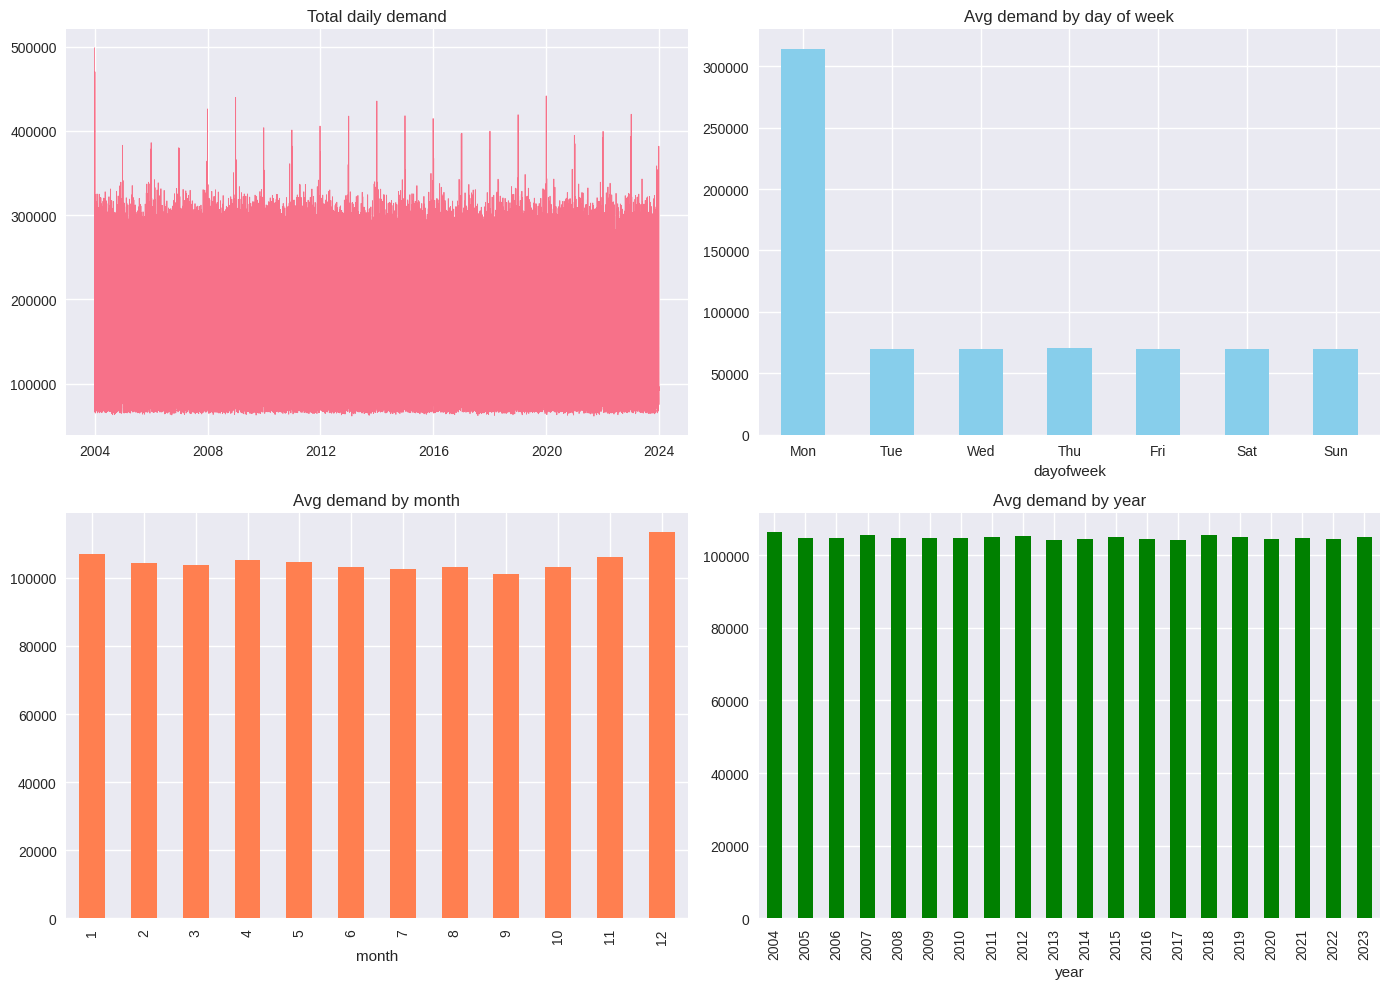


=== SKU-LEVEL INSIGHTS ===

Top 10 SKUs by total_demand:
          avg_demand  std_demand  total_demand  num_days    cv
sku_id                                                        
SKU_0002      111.25      168.46      16253888    146100  1.51
SKU_0039      110.92      166.86      16204953    146100  1.50
SKU_0050      110.83      167.13      16192253    146100  1.51
SKU_0022      110.82      167.38      16190993    146100  1.51
SKU_0003      110.79      166.75      16187035    146100  1.51
SKU_0011      110.78      166.70      16184693    146100  1.50
SKU_0017      110.49      166.86      16142651    146100  1.51
SKU_0035      110.17      165.96      16095342    146100  1.51
SKU_0030      105.83      158.66      15461459    146100  1.50
SKU_0042      105.81      159.01      15459516    146100  1.50

Top 10 SKUs by volatility (CV, avg>0):
          avg_demand  std_demand  total_demand  num_days    cv
sku_id                                                        
SKU_0002      111.25

In [2]:
# =============================================================================
# 01 - EDA: LOAD DATA
# =============================================================================

# Master / driver tables
sku = pd.read_csv(DATA_ROOT / "sku_master (1).csv")
location = pd.read_csv(DATA_ROOT / "location_master (1).csv")
festival = pd.read_csv(DATA_ROOT / "festival_calendar (1).csv", parse_dates=["date"])
macro = pd.read_csv(DATA_ROOT / "monthly_macro (1).csv")

# Core time-series and drivers
daily_ts = pd.read_csv(DATA_ROOT / "daily_timeseries (1).csv", parse_dates=["date"])
shipment = pd.read_csv(DATA_ROOT / "shipment_data.csv")
competitor = pd.read_csv(DATA_ROOT / "competitor_activity.csv", parse_dates=["date"])
weather = pd.read_csv(DATA_ROOT / "weather_data.csv", parse_dates=["date"])

print("Loaded all Kaggle FMCG tables.")
print(f"daily_ts shape: {daily_ts.shape[0]:,} rows x {daily_ts.shape[1]} cols")
print("Date range:", daily_ts["date"].min(), "→", daily_ts["date"].max())
print("Unique SKUs:", daily_ts["sku_id"].nunique(), "Locations:", daily_ts["location_id"].nunique())
# =============================================================================
# 01 - EDA: QUICK STRUCTURE HELPERS
# =============================================================================

def quick_info(name, df):
    print(f"=== {name} ===")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("\nDtypes:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isna().sum())
    print("\nFirst 5 rows:")
    display(df.head())
    print("-" * 70)

quick_info("SKU MASTER", sku)
quick_info("LOCATION MASTER", location)
quick_info("FESTIVAL CALENDAR", festival)
quick_info("MONTHLY MACRO", macro)
quick_info("DAILY TIMESERIES", daily_ts)
quick_info("SHIPMENT DATA", shipment)
quick_info("COMPETITOR ACTIVITY", competitor)
quick_info("WEATHER DATA", weather)
# =============================================================================
# 01 - EDA: DATA QUALITY ON daily_ts
# =============================================================================

print("\n=== DATA QUALITY: daily_ts ===")

missing_pct = (daily_ts.isna().sum() / len(daily_ts) * 100).round(2)
missing_df = (
    pd.DataFrame({"missing_count": daily_ts.isna().sum(), "missing_%": missing_pct})
    .query("missing_count > 0")
    .sort_values("missing_%", ascending=False)
)
print("\nMissing (non-zero):")
print(missing_df)

dups = daily_ts.duplicated(subset=["date", "sku_id", "location_id"]).sum()
print("\nDuplicate (date, sku_id, location_id):", dups)

target = daily_ts["actual_demand"]
zero_demand = (target == 0).sum()
neg_demand = (target < 0).sum()
print(f"\nZero actual_demand: {zero_demand:,} ({zero_demand/len(target)*100:.2f}%)")
print(f"Negative actual_demand: {neg_demand:,}")
# =============================================================================
# 01 - EDA: TARGET DISTRIBUTION
# =============================================================================

print("\n=== TARGET: actual_demand DISTRIBUTION ===")

print(target.describe())

Q1, Q3 = target.quantile(0.25), target.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (target < Q1 - 1.5 * IQR) | (target > Q3 + 1.5 * IQR)
print(f"\nOutliers (IQR): {outlier_mask.sum():,} "
      f"({outlier_mask.sum()/len(target)*100:.2f}%)")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(target, bins=50, edgecolor="black", alpha=0.7)
axes[0].set_title("actual_demand distribution")

axes[1].hist(np.log1p(target), bins=50, edgecolor="black", alpha=0.7, color="green")
axes[1].set_title("log1p(actual_demand) distribution")

axes[2].boxplot(target, vert=True)
axes[2].set_title("actual_demand boxplot")

plt.tight_layout()
plt.show()
# =============================================================================
# 01 - EDA: CORRELATIONS
# =============================================================================

print("\n=== CORRELATIONS WITH actual_demand (numeric columns) ===")

numeric_cols = daily_ts.select_dtypes(include=[np.number]).columns.tolist()
leak_like = ["expected_demand", "unfulfilled_demand"]
numeric_cols = [c for c in numeric_cols if c not in leak_like]

corrs = daily_ts[numeric_cols].corr()["actual_demand"].drop("actual_demand").sort_values(ascending=False)

print("\nTop 10 positive:")
print(corrs.head(10))

print("\nTop 10 negative:")
print(corrs.tail(10))

top_corr_features = corrs.abs().nlargest(15).index.tolist() + ["actual_demand"]

plt.figure(figsize=(10, 8))
sns.heatmap(daily_ts[top_corr_features].corr(), cmap="coolwarm", center=0)
plt.title("Top correlations with actual_demand")
plt.tight_layout()
plt.show()
# =============================================================================
# 01 - EDA: TEMPORAL PATTERNS
# =============================================================================

print("\n=== TEMPORAL PATTERNS (AGGREGATED) ===")

daily_agg = (
    daily_ts.groupby("date")["actual_demand"]
    .sum()
    .reset_index()
    .rename(columns={"actual_demand": "total_demand"})
)

daily_agg["dayofweek"] = daily_agg["date"].dt.dayofweek
daily_agg["month"] = daily_agg["date"].dt.month
daily_agg["year"] = daily_agg["date"].dt.year

weekly_avg = daily_agg.groupby("dayofweek")["total_demand"].mean()
monthly_avg = daily_agg.groupby("month")["total_demand"].mean()
yearly_avg = daily_agg.groupby("year")["total_demand"].mean()

print("\nWeekly average:")
print(weekly_avg)
print("\nMonthly average:")
print(monthly_avg)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(daily_agg["date"], daily_agg["total_demand"], linewidth=0.6)
axes[0, 0].set_title("Total daily demand")

weekly_avg.plot(kind="bar", ax=axes[0, 1], color="skyblue")
axes[0, 1].set_title("Avg demand by day of week")
axes[0, 1].set_xticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)

monthly_avg.plot(kind="bar", ax=axes[1, 0], color="coral")
axes[1, 0].set_title("Avg demand by month")

yearly_avg.plot(kind="bar", ax=axes[1, 1], color="green")
axes[1, 1].set_title("Avg demand by year")

plt.tight_layout()
plt.show()
# =============================================================================
# 01 - EDA: SKU / LOCATION & LIGHT LEAK CHECK
# =============================================================================

print("\n=== SKU-LEVEL INSIGHTS ===")

sku_metrics = (
    daily_ts.groupby("sku_id")
    .agg(
        avg_demand=("actual_demand", "mean"),
        std_demand=("actual_demand", "std"),
        total_demand=("actual_demand", "sum"),
        num_days=("date", "count"),
    )
    .round(2)
)
sku_metrics["cv"] = (sku_metrics["std_demand"] / sku_metrics["avg_demand"]).round(2)

print("\nTop 10 SKUs by total_demand:")
print(sku_metrics.sort_values("total_demand", ascending=False).head(10))

print("\nTop 10 SKUs by volatility (CV, avg>0):")
print(
    sku_metrics[sku_metrics["avg_demand"] > 0]
    .sort_values("cv", ascending=False)
    .head(10)
)

print("\n=== LOCATION-LEVEL INSIGHTS ===")

loc_metrics = (
    daily_ts.groupby("location_id")
    .agg(
        avg_demand=("actual_demand", "mean"),
        total_demand=("actual_demand", "sum"),
        num_days=("date", "count"),
    )
    .round(2)
)

print("\nTop 10 locations by total_demand:")
print(loc_metrics.sort_values("total_demand", ascending=False).head(10))

print("\n=== SIMPLE LEAKAGE CHECK ===")
for col in ["expected_demand", "incoming_stock"]:
    if col in daily_ts.columns:
        cval = daily_ts[["actual_demand", col]].corr().iloc[0, 1]
        print(f"corr(actual_demand, {col}) = {cval:.4f}")
    else:
        print(col, "not present")


In [3]:
# =============================================================================
# 02 - FEATURE ENGINEERING: BUILD training_table
# =============================================================================

def add_sku_features(df: pd.DataFrame) -> pd.DataFrame:
    return df.merge(sku, on="sku_id", how="left")

def add_location_features(df: pd.DataFrame) -> pd.DataFrame:
    return df.merge(location, on="location_id", how="left")

def add_festival_flags(df: pd.DataFrame) -> pd.DataFrame:
    fest = festival[["date"]].copy()
    fest["is_festival"] = 1
    out = df.merge(fest, on="date", how="left")
    out["is_festival"] = out["is_festival"].fillna(0).astype(int)
    return out

def add_macro_features(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    tmp["month_key"] = tmp["date"].dt.to_period("M").dt.to_timestamp()
    macro_tmp = macro.copy()
    macro_tmp["month_key"] = pd.to_datetime(macro_tmp["month"]).dt.to_period("M").dt.to_timestamp()
    macro_tmp = macro_tmp.drop_duplicates(subset=["month_key"])
    out = tmp.merge(
        macro_tmp[["month_key", "gdp_growth", "cpi_index", "consumer_confidence"]],
        on="month_key",
        how="left",
    )
    return out.drop(columns=["month_key"])

def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    tmp["day_of_week"] = tmp["date"].dt.weekday
    tmp["week_of_year"] = tmp["date"].dt.isocalendar().week.astype(int)
    tmp["day_of_month"] = tmp["date"].dt.day
    tmp["month"] = tmp["date"].dt.month
    tmp["year"] = tmp["date"].dt.year
    tmp["is_weekend"] = tmp["day_of_week"].isin([5, 6]).astype(int)
    tmp["quarter"] = tmp["date"].dt.quarter
    return tmp

def add_price_promo_features(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    if {"price", "base_price", "mrp"}.issubset(tmp.columns):
        tmp["price_to_base"] = tmp["price"] / tmp["base_price"]
        tmp["discount_depth"] = (tmp["mrp"] - tmp["price"]) / tmp["mrp"]
        tmp["discount_depth"] = tmp["discount_depth"].clip(-1, 1)
    return tmp

print("\n=== BUILDING training_table (02) ===")

df_feat = (
    daily_ts.copy()
    .pipe(add_sku_features)
    .pipe(add_location_features)
    .pipe(add_festival_flags)
    .pipe(add_macro_features)
    .pipe(add_calendar_features)
    .pipe(add_price_promo_features)
)

# Use Kaggle’s existing lag/rolling columns; drop rows where they are NaN
lag_like = [
    "loc_lag_1", "loc_lag_7", "loc_lag_14", "loc_lag_30",
    "loc_rolling_7_mean", "loc_rolling_30_mean",
    "chan_lag_1", "chan_rolling_7_mean",
]
lag_cols = [c for c in lag_like if c in df_feat.columns]
if lag_cols:
    df_feat = df_feat.dropna(subset=lag_cols)

print("training_table shape:", df_feat.shape)
print("Example columns:", list(df_feat.columns)[:20])

train_path = OUT_ROOT / "training_table.csv"
df_feat.to_csv(train_path, index=False)
print("Saved training_table.csv to", train_path)



=== BUILDING training_table (02) ===
training_table shape: (7308000, 93)
Example columns: ['date', 'sku_id', 'location_id', 'base_price_x', 'brand_x', 'category_x', 'sku_name_x', 'segment_x', 'pack_size_x', 'material_x', 'cost_x', 'mrp_x', 'shelf_life_days_x', 'life_category_x', 'abc_class_x', 'min_order_qty_x', 'lead_time_days_x', 'is_seasonal_x', 'city_x', 'region_x']
Saved training_table.csv to /kaggle/working/training_table.csv


Using 47 numeric features.
Train size: (6942000, 47) Test size: (366000, 47)
Train range: 2004-01-01 00:00:00 → 2022-12-30 00:00:00
Test range : 2022-12-31 00:00:00 → 2023-12-31 00:00:00

Training XGBoost with GPU...
Training done.

TRAIN metrics:
MAE  : 22.076
RMSE : 38.049
R²   : 0.9415
MAPE : 73.55%

TEST metrics:
MAE  : 21.786
RMSE : 37.641
R²   : 0.9426
MAPE : 67.28%

Top 20 features:
                  feature  importance
0              chan_lag_1    0.345176
1              is_weekend    0.310830
2             day_of_week    0.160231
3   demand_yoy_pct_change    0.082067
4              loc_lag_14    0.024111
5        elasticity_proxy    0.013000
6               loc_lag_7    0.011813
7      loc_rolling_7_mean    0.007358
8               loc_lag_1    0.004737
9       loc_rolling_7_std    0.004151
10    chan_rolling_7_mean    0.003882
11            is_festival    0.003324
12             promo_flag    0.003287
13          opening_stock    0.003132
14          stockout_flag    0.002938

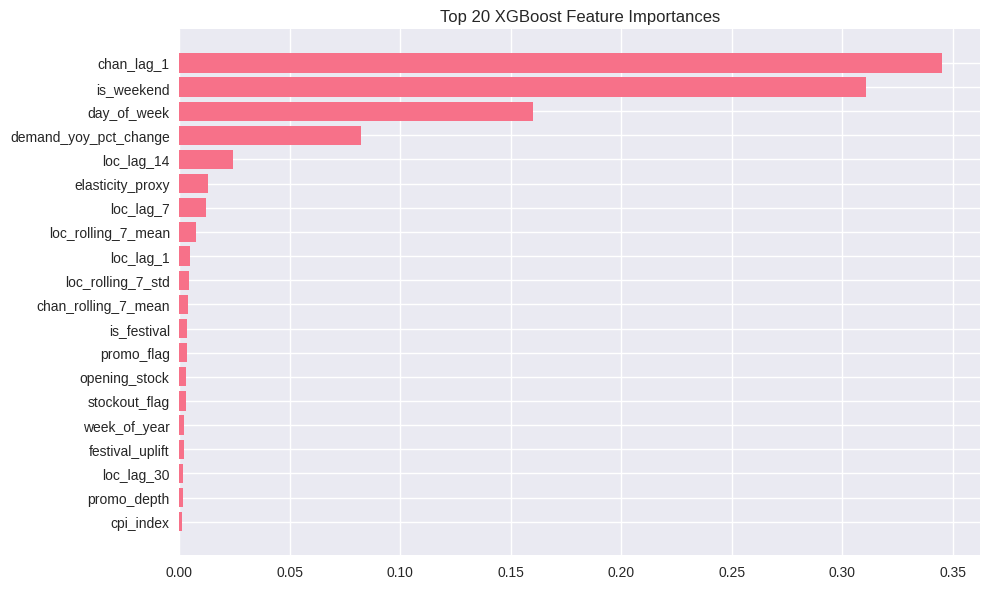

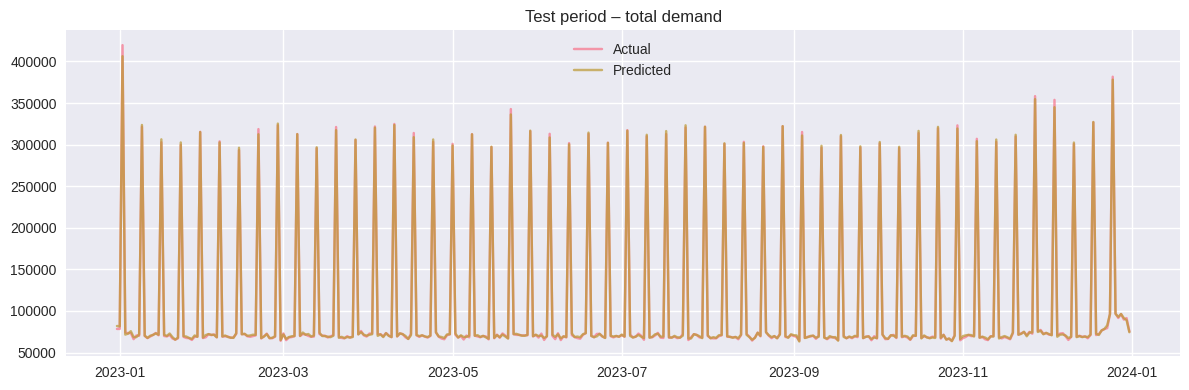


Saved:
 model: /kaggle/working/xgb_baseline_gpu_model.json
 metrics: /kaggle/working/xgb_baseline_gpu_metrics.csv
 predictions: /kaggle/working/xgb_baseline_gpu_test_predictions.csv


In [4]:
# 03_model_baseline_xgboost_gpu.ipynb
# Uses df_feat from 02, with GPU acceleration (T4-compatible)

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =============================================================================
# 1. PREPARE MODELLING DATA
# =============================================================================

TARGET_COL = "actual_demand"

if TARGET_COL not in df_feat.columns:
    raise ValueError(f"{TARGET_COL} not found in df_feat columns.")

df_model = df_feat.copy()
df_model = df_model[~df_model[TARGET_COL].isna()].reset_index(drop=True)

# Drop duplicate *_y columns if present
for c in list(df_model.columns):
    if c.endswith("_y"):
        df_model = df_model.drop(columns=[c])

# Rename *_x back to base names
rename_map = {c: c.replace("_x", "") for c in df_model.columns if c.endswith("_x")}
df_model = df_model.rename(columns=rename_map)

# Build feature list: numeric, excluding IDs and leaky cols
id_cols = ["date", "sku_id", "location_id", "sku_name", "city", "region"]
leak_cols = [
    "expected_demand",
    "unfulfilled_demand",
    "incoming_stock",
    "closing_stock",
    "reorder_point",
    "safety_stock",
]

num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [
    c for c in num_cols
    if c not in [TARGET_COL] + leak_cols
]

print("Using", len(feature_cols), "numeric features.")

# Time-based split: last 365 days as test
max_date = df_model["date"].max()
split_date = max_date - pd.Timedelta(days=365)

train_mask = df_model["date"] < split_date
test_mask = df_model["date"] >= split_date

X_train = df_model.loc[train_mask, feature_cols]
y_train = df_model.loc[train_mask, TARGET_COL]
X_test = df_model.loc[test_mask, feature_cols]
y_test = df_model.loc[test_mask, TARGET_COL]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train range:", df_model.loc[train_mask, "date"].min(), "→", df_model.loc[train_mask, "date"].max())
print("Test range :", df_model.loc[test_mask, "date"].min(), "→", df_model.loc[test_mask, "date"].max())

# =============================================================================
# 2. METRICS
# =============================================================================

def metrics_fn(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    denom = np.maximum(np.abs(y_true), 1)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100
    print(f"\n{name} metrics:")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mape}

# =============================================================================
# 3. XGBOOST MODEL (GPU)
# =============================================================================

params = dict(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="gpu_hist",   # GPU acceleration
    device="cuda",            # use CUDA device if available
)

model = xgb.XGBRegressor(**params)
print("\nTraining XGBoost with GPU...")
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
print("Training done.")

y_train_pred = np.maximum(model.predict(X_train), 0)
y_test_pred = np.maximum(model.predict(X_test), 0)

train_metrics = metrics_fn(y_train, y_train_pred, "TRAIN")
test_metrics = metrics_fn(y_test, y_test_pred, "TEST")

# =============================================================================
# 4. FEATURE IMPORTANCE & DIAGNOSTICS
# =============================================================================

importances = model.feature_importances_
fi = (
    pd.DataFrame({"feature": feature_cols, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 20 features:")
print(fi.head(20))

plt.figure(figsize=(10, 6))
top20 = fi.head(20)
plt.barh(range(len(top20)), top20["importance"])
plt.yticks(range(len(top20)), top20["feature"])
plt.gca().invert_yaxis()
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# Aggregate test period
test_plot = df_model.loc[test_mask, ["date", TARGET_COL]].copy()
test_plot["pred"] = y_test_pred

daily_agg = (
    test_plot.groupby("date")[[TARGET_COL, "pred"]]
    .sum()
    .reset_index()
    .rename(columns={TARGET_COL: "actual"})
)

plt.figure(figsize=(12, 4))
plt.plot(daily_agg["date"], daily_agg["actual"], label="Actual", alpha=0.7)
plt.plot(daily_agg["date"], daily_agg["pred"], label="Predicted", alpha=0.7)
plt.title("Test period – total demand")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# 5. SAVE ARTIFACTS
# =============================================================================

OUT_ROOT = Path("/kaggle/working")

model_path = OUT_ROOT / "xgb_baseline_gpu_model.json"
model.save_model(model_path)

metrics_df = pd.DataFrame(
    {
        "dataset": ["train", "test"],
        "MAE": [train_metrics["MAE"], test_metrics["MAE"]],
        "RMSE": [train_metrics["RMSE"], test_metrics["RMSE"]],
        "R2": [train_metrics["R2"], test_metrics["R2"]],
        "MAPE": [train_metrics["MAPE"], test_metrics["MAPE"]],
    }
)
metrics_path = OUT_ROOT / "xgb_baseline_gpu_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)

pred_df = df_model.loc[test_mask, ["date", "sku_id", "location_id"]].copy()
pred_df["actual"] = y_test.values
pred_df["predicted"] = y_test_pred
pred_path = OUT_ROOT / "xgb_baseline_gpu_test_predictions.csv"
pred_df.to_csv(pred_path, index=False)

print("\nSaved:")
print(" model:", model_path)
print(" metrics:", metrics_path)
print(" predictions:", pred_path)
